## Import packages:

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick

from pandas.api.types import CategoricalDtype
# cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cats = [ 'Mánudagur', 'Þriðjudagur', 'Miðvikudagur', 'Fimmtudagur', 'Föstudagur', 'Laugardagur', 'Sunnudagur']
cat_type = CategoricalDtype(categories=cats, ordered=True)

### Read dataset:

In [38]:
os.listdir('./FlightData')

['Actual',
 'flight_departures.pickle',
 'flight_departures_actual.pickle',
 'flight_departures_plan.pickle',
 'Plan',
 '_Backup']

In [183]:
df_orig = pd.read_pickle(os.path.join('Flightdata', 'flight_departures.pickle')).drop(columns=["Type", "CreationDate"])
df_orig['WeekDay']=df['WeekDay'].astype(cat_type)

df_a = df_orig[df.Scenario == 'Actual'].drop(columns=['Scenario'])
df_p = df_orig[df.Scenario == 'Plan'].drop(columns=['Scenario'])

current_week = df_a.Date.max().week

40

In [117]:
airline = 'Icelandair'
week = current_week - 1
df_w = df_a[df_a.Date.dt.week == week]
week_airline = df_w[df_w.Airline == airline].drop(
    columns=['Airline','Date','Confirmed','Scheduled'])
week_airline = week_airline.set_index(['WeekDay', 'FlightNumber']).sort_index(level=0)

In [389]:
result = w38_play.groupby(['WeekDay', 'FlightNumber', 'Destination'])['pMins'].mean().dropna()
# result_destination = w38_play.groupby(['Destination'])['pMins'].mean()
# result_weekday = w38_play.groupby(['WeekDay'])['pMins'].mean()

In [81]:
result[result <= 0].shape

(14,)

In [82]:
result_destination = result.groupby(level=2).apply(lambda x: 100 * x[x<=0].count()/float(x.count()) )
result_weekday = result.groupby(level=0).apply(lambda x: 100 * x[x<=0].count()/float(x.count()) )

<ipython-input-82-80d33d017f98>:2: RuntimeWarning: invalid value encountered in true_divide
  result_weekday = result.groupby(level=0).apply(lambda x: 100 * x[x<=0].count()/float(x.count()) )


Text(0, 0.5, 'Stundvísihlutfall')

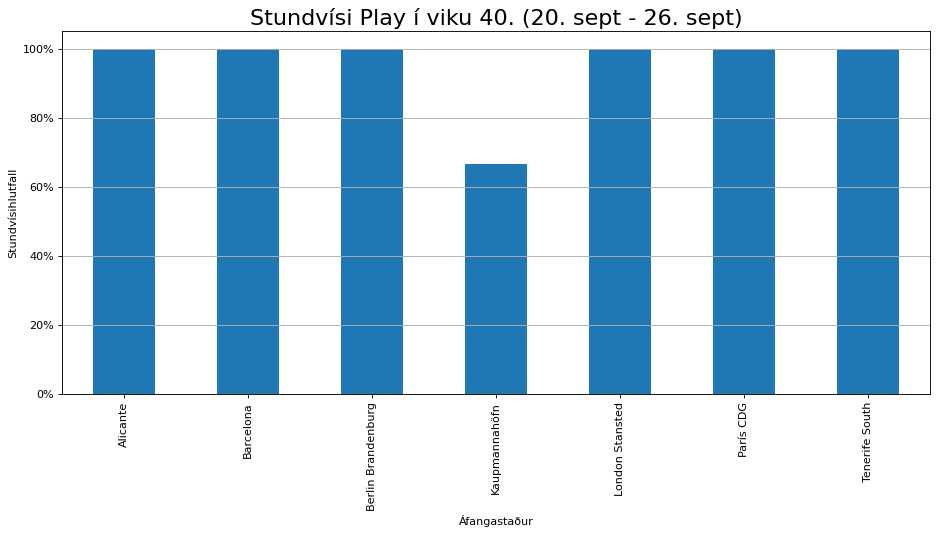

In [83]:
figure(figsize=(14, 6), dpi=80)
ax = result_destination.plot.bar()
ax.set_title(f'Stundvísi {airline} í viku {week}. (20. sept - 26. sept)', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Áfangastaður")
ax.set_ylabel("Stundvísihlutfall")

Text(0, 0.5, 'Stundvísihlutfall')

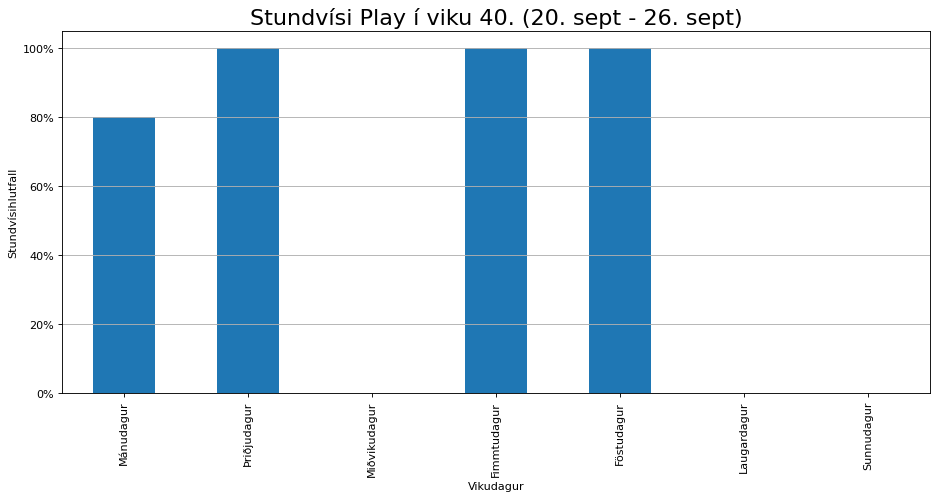

In [84]:
figure(figsize=(14, 6), dpi=80)
ax = result_weekday.plot.bar(x = 'Vikudagur', y='Stundvísihlutfall')
ax.set_title(f'Stundvísi {airline} í viku {week}. (20. sept - 26. sept)', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vikudagur")
ax.set_ylabel("Stundvísihlutfall")

### Punctuality for all airlines:

In [388]:
week = current_week
df_w = df_a[df_a.Date.dt.week == week]

result_airlines = df_w.groupby(['WeekDay', 'FlightNumber', 'Airline'])['pMins'].mean().dropna()
result_airlines_mean = df_w.groupby(['Airline'])['pMins'].mean().dropna()
result_airlines_median = df_w.groupby(['Airline'])['pMins'].median().dropna()
result_airlines_count = df_w.groupby(['Airline'])['pMins'].count().dropna()
result_airlines_pRatio = result_airlines.groupby(level=2).apply(lambda x: 100 * x[x<=0].count()/float(x.count()) )
result_airlines_cRatio = result_airlines_count.apply(lambda x: 100 * x / result_airlines_count.sum() )

Text(0, 0.5, 'Stundvísihlutfall')

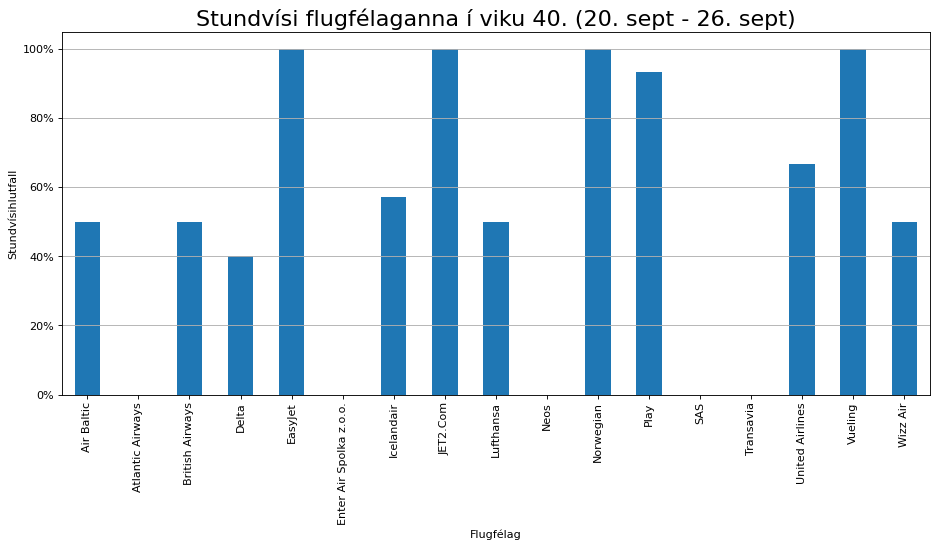

In [326]:
figure(figsize=(14, 6), dpi=80)
ax = result_airlines_pRatio.plot.bar(x = 'Vikudagur', y='Stundvísihlutfall')
ax.set_title(f'Stundvísi flugfélaganna í viku {week}. (20. sept - 26. sept)', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Flugfélag")
ax.set_ylabel("Stundvísihlutfall")

### Þróun á stundvísi fyrir Icelandair og Play

In [381]:
df = df_a[df_a.Date.dt.week < current_week]
# df = df[df.pMins > 0]

df = df[df.Airline.isin(['Icelandair', 'Play'])]
df = df.assign(WoY = df.Date.dt.strftime("%Y-%W"))
df_result = df.groupby(['WoY', 'WeekDay', 'FlightNumber', 'Airline'])['pMins'].mean().dropna()
df_result_week_mean = df.groupby(['WoY', 'Airline'])['pMins'].mean().dropna()
df_result_week_median = df.groupby(['WoY', 'Airline'])['pMins'].median().dropna()
df_result_week_sum = df.groupby(['WoY', 'Airline'])['pMins'].sum().dropna()
df_result_week_count = df.groupby(['WoY', 'Airline'])['pMins'].count().dropna()
df_result_week_cRatio = df_result_week_count.groupby(level=0).apply(lambda x: 100 * (x / x.sum()))
df_result_week_pRatio = df_result.groupby(['WoY', 'Airline']).apply(lambda x: 100 * (x[x<=0].count() / x.count()))

Text(0, 0.5, 'Stundvísihlutfall')

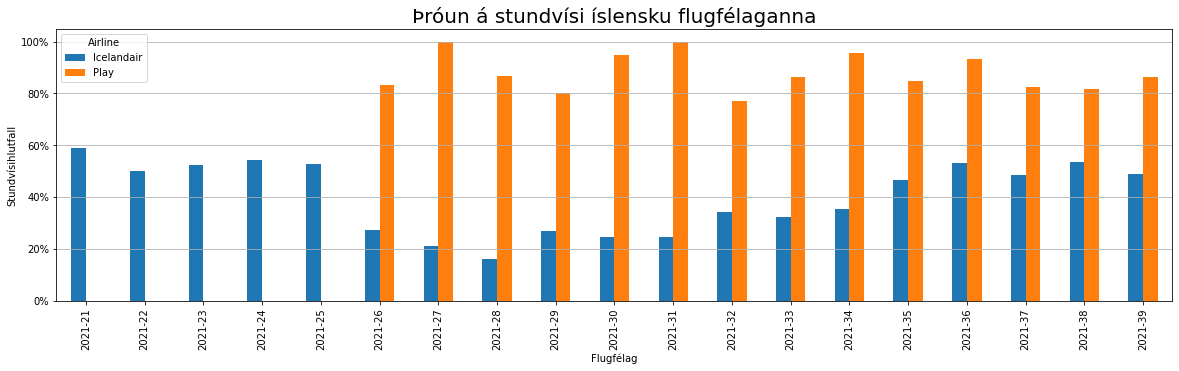

In [382]:
# figure(figsize=(2000, 6), dpi=80)
ax = df_result_week_pRatio.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Þróun á stundvísi íslensku flugfélaganna', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Flugfélag")
ax.set_ylabel("Stundvísihlutfall")

Text(0, 0.5, 'Fjöldi flugferða í viku')

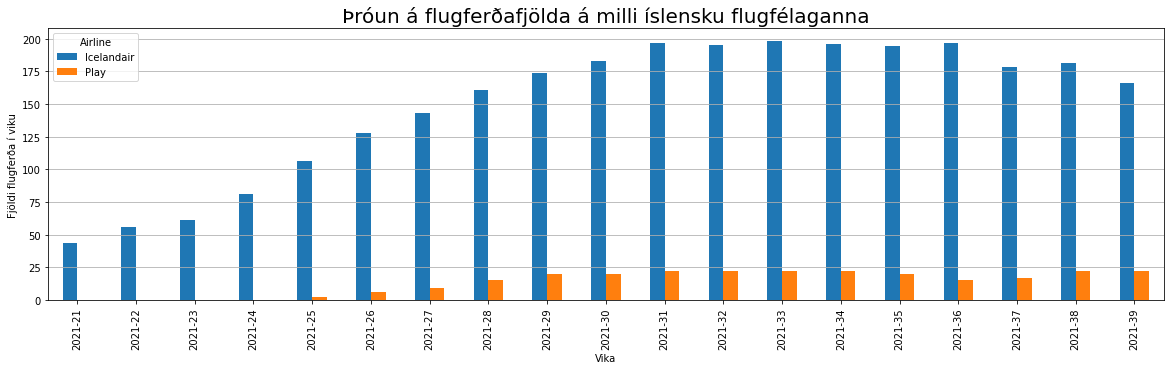

In [383]:
ax = df_result_week_count.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Þróun á flugferðafjölda á milli íslensku flugfélaganna', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Fjöldi flugferða í viku")

Text(0, 0.5, 'Flugferðahlutfall')

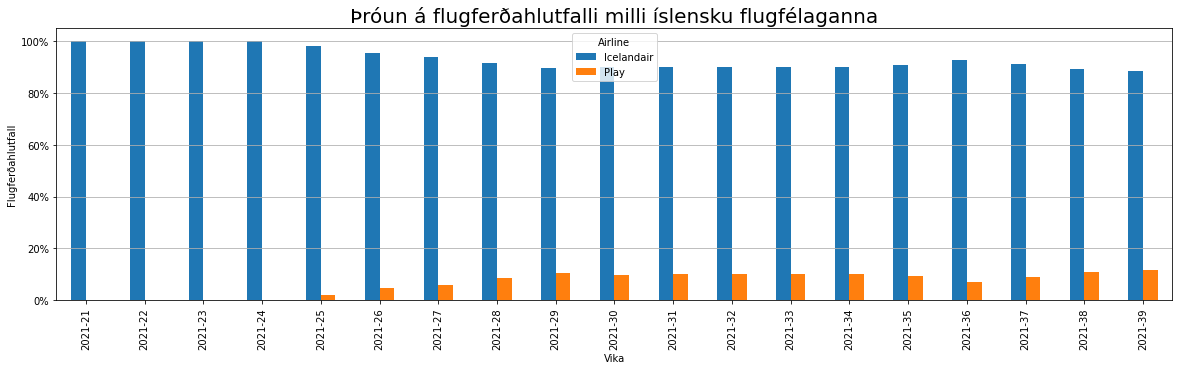

In [384]:
# figure(figsize=(2000, 6), dpi=80)
ax = df_result_week_cRatio.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Þróun á flugferðahlutfalli milli íslensku flugfélaganna', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Flugferðahlutfall")

Text(0, 0.5, 'Mínútur')

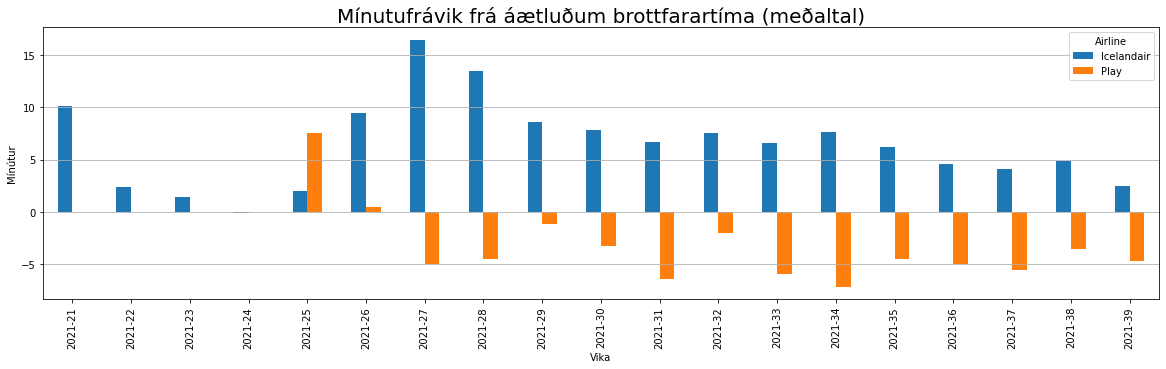

In [385]:
ax = df_result_week_mean.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Mínutufrávik frá áætluðum brottfarartíma (meðaltal)', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Mínútur")

Text(0, 0.5, 'Mínútur')

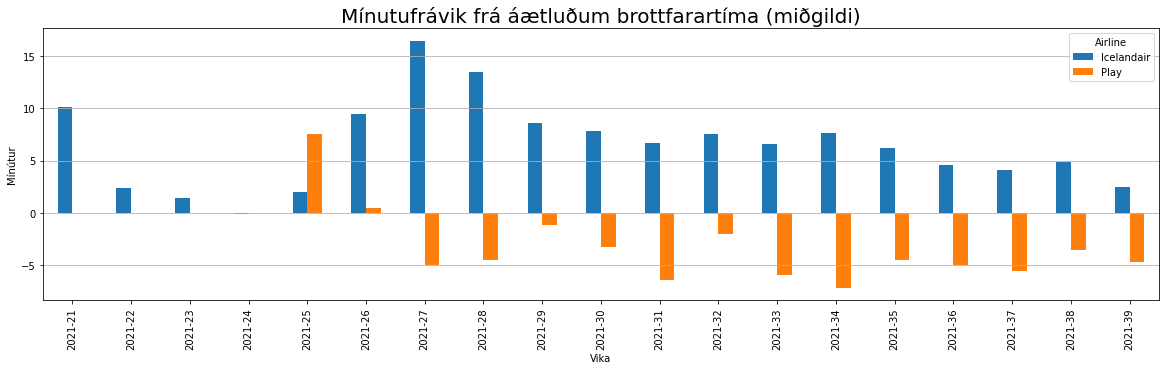

In [386]:
ax = df_result_week_mean.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Mínutufrávik frá áætluðum brottfarartíma (miðgildi)', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Mínútur")

Text(0, 0.5, 'Mínútur')

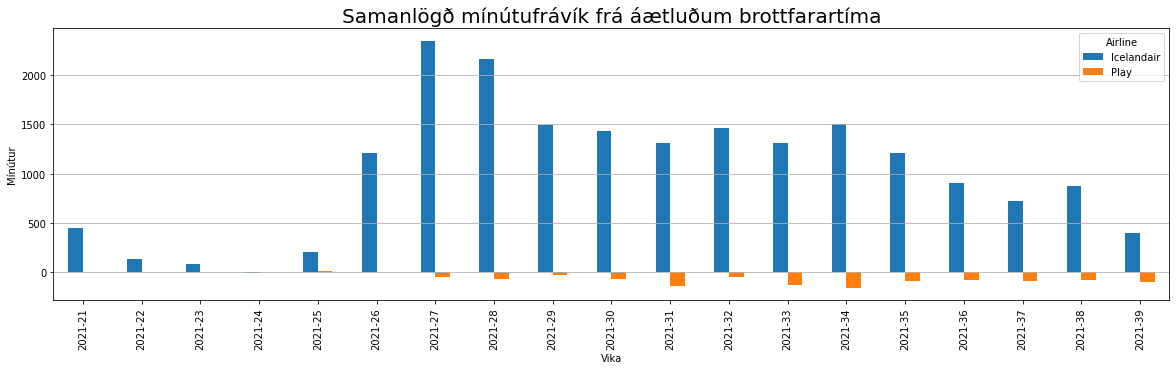

In [387]:
ax = df_result_week_sum.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Samanlögð mínútufrávík frá áætluðum brottfarartíma', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Mínútur")